# LSTM을 활용한 전려소요 예측 모델

- TensorFlow Dataset 클래스를 활용하여 전력소요 데이터 구축
- LSTM 을 활용한 전력소요 예측 모델 구축

## 필요한 모듈 import

In [1]:
from matplotlib import font_manager, rc
import matplotlib, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import platform
import tensorflow as tf

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
plt.rcParams['axes.unicode_minus'] == False

False

## 데이터 (FinanceDataReader)

In [2]:
# 시간별_전력데이터 전체 (2012-06-01 ~ 2022-04-07)
path = '../processing_data/시간별_전력데이터.csv'
df_s = pd.read_csv(path, encoding='cp949')

In [3]:
# 시간별_전력데이터 전체 (2012-06-01 ~ 2022-04-07)
path = '../processing_data/시간별_전력데이터.csv'
df = pd.read_csv(path, encoding='cp949')

### 컬럼 설명

- `공급능력`:   전력생산량
- `현재수요`:   그날 사용한 전력량
- `공급예비력`:   전력 생산하고 남은 양
- `전력예비율`:  전력예비율 = (총 공급 전력량-최대 전력수요 / 최대 전력 수요) × 100
전력예비율이 6% 이하로 떨어지면 블랙아웃 가능성이 높아졌다는 뜻


In [5]:
df.tail()

,Unnamed: 0,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),datetime
86333,86333,83646.11667,69966.39167,13679.70833,19.555125,2022-04-07 19:00
86334,86334,83715.82500,68310.45833,15405.36667,22.558508,2022-04-07 20:00
86335,86335,83529.48333,66472.92500,17056.57500,25.663192,2022-04-07 21:00
86336,86336,83061.11667,65215.06667,17846.05000,27.372808,2022-04-07 22:00
86337,86337,82854.06667,64148.23333,18705.82500,29.185117,2022-04-07 23:00


## 시각화

In [6]:
# plt.figure(figsize=(16, 9))
# sns.lineplot(y=df['현재수요(MW)'], x=df['datetime'])
# plt.xlabel('time')
# plt.ylabel('price')
# plt.grid(True)
# plt.show()

In [7]:
df.drop( labels=['Unnamed: 0'],inplace =True,axis=1)

In [8]:
df

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),datetime
0,64355.00000,50990.28917,13364.71167,26.224017,2012-06-01 0:00
1,64355.00000,50064.35500,14290.64667,28.545997,2012-06-01 1:00
2,64559.16667,49986.54250,14572.62333,29.156328,2012-06-01 2:00
3,64845.00000,50093.08083,14751.91833,29.453125,2012-06-01 3:00
4,64845.00000,50456.72583,14388.27417,28.518804,2012-06-01 4:00
...,...,...,...,...,...
86333,83646.11667,69966.39167,13679.70833,19.555125,2022-04-07 19:00
86334,83715.82500,68310.45833,15405.36667,22.558508,2022-04-07 20:00
86335,83529.48333,66472.92500,17056.57500,25.663192,2022-04-07 21:00
86336,83061.11667,65215.06667,17846.05000,27.372808,2022-04-07 22:00


In [9]:
df = df.set_index('datetime')

In [10]:
time_steps = [['2013', '2014'], 
              ['2014', '2015'], 
              ['2015', '2016'],
              ['2016', '2017'], 
              ['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

In [11]:
df.loc[(df.index > time_steps[0][0]) & (df.index < time_steps[0][1])]

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트)
datetime,,,,
2013-01-01 0:00,77740.00000,60326.23583,17413.76333,28.881679
2013-01-01 1:00,77740.00000,57977.46917,19762.52917,34.102047
2013-01-01 2:00,77589.33333,56238.06000,21351.27250,37.975934
2013-01-01 3:00,76836.00000,55187.58750,21648.41167,39.228697
2013-01-01 4:00,76836.00000,54461.06417,22374.93500,41.085581
...,...,...,...,...
2013-12-31 19:00,81276.00000,58535.28333,22740.71667,38.858042
2013-12-31 20:00,81276.00000,57674.38083,23601.61917,40.923327
2013-12-31 21:00,81276.00000,57299.69833,23976.30167,41.848352


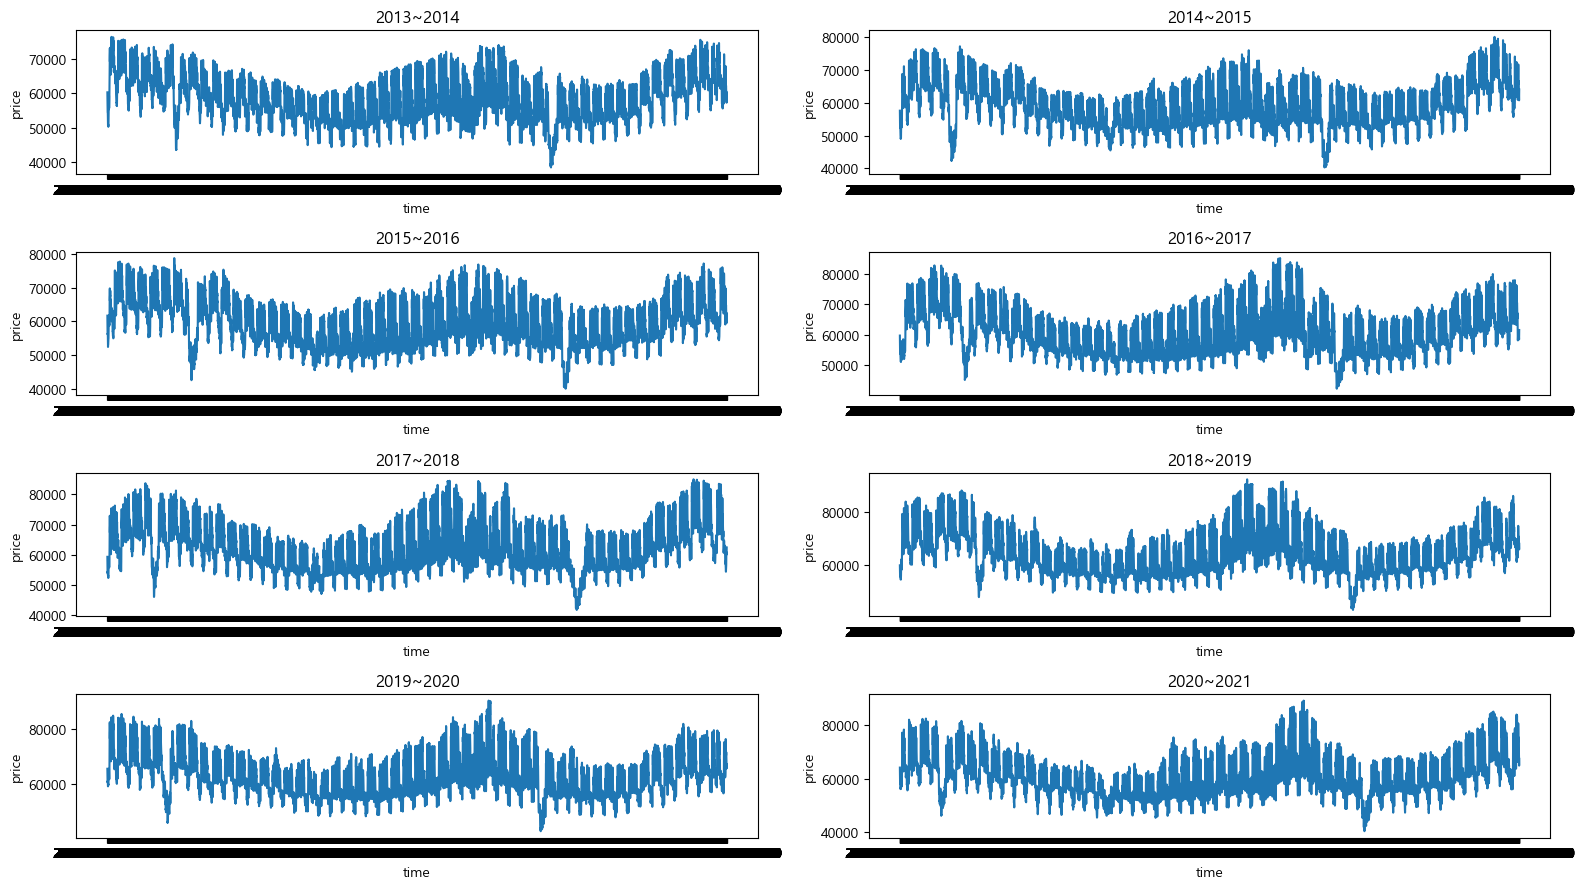

In [12]:
time_steps = [['2013', '2014'], 
              ['2014', '2015'], 
              ['2015', '2016'],
              ['2016', '2017'], 
              ['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

fig, axes = plt.subplots(4, 2)
fig.set_size_inches(16, 9)
for i in range(8):
    ax = axes[i//2, i%2]
    df_1 = df.loc[(df.index > time_steps[i][0]) & (df.index < time_steps[i][1])]
    sns.lineplot(y=df_1['현재수요(MW)'], x=df_1.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

전력소요 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['공급능력(MW)', '현재수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.04961463, 0.25421718, 0.18589205, 0.18998456],
       [0.04961463, 0.23753134, 0.20214105, 0.20959629],
       [0.05314289, 0.23612912, 0.20708938, 0.21475122],
       ...,
       [0.38097472, 0.53322265, 0.25067962, 0.18524776],
       [0.37288074, 0.51055536, 0.26453392, 0.19968739],
       [0.36930264, 0.49133045, 0.27962189, 0.21499437]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [14]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [15]:
df.shape

(86338, 4)

## train / test 분할

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# 1년치 0.423
x_train, x_test, y_train, y_test = train_test_split(df.drop('현재수요(MW)', 1), df['현재수요(MW)'], test_size=0.10146, random_state=0, shuffle=False)

C:\Users\ban05\AppData\Local\Temp\ipykernel_14704\697061679.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('현재수요(MW)', 1), df['현재수요(MW)'], test_size=0.10146, random_state=0, shuffle=False)


In [18]:
x_train.shape, y_train.shape

((77578, 3), (77578,))

In [19]:
x_test.shape, y_test.shape

((8760, 3), (8760,))

In [20]:
x_train

,공급능력(MW),공급예비력(MW),공급예비율(퍼센트)
0,0.049615,0.185892,0.189985
1,0.049615,0.202141,0.209596
2,0.053143,0.207089,0.214751
3,0.058082,0.210236,0.217258
4,0.058082,0.203854,0.209367
...,...,...,...
77573,0.271091,0.224671,0.182072
77574,0.281228,0.217399,0.173092
77575,0.290622,0.254880,0.208029
77576,0.285293,0.270705,0.225563


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

---



In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    # y.shape읙 값을 (y, ) -> (y,1)로 변경
    series = tf.expand_dims(series, axis=-1)
    #  series에서 TensorFlow 데이터세트를 생성합니다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [22]:
WINDOW_SIZE=365
BATCH_SIZE=32

In [23]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
y_test.shape

(8760,)

In [25]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 365, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [27]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [28]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [29]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
   2413/Unknown - 200s 82ms/step - loss: 0.0019 - mse: 0.0037
Epoch 1: val_loss improved from inf to 0.00043, saving model to tmp\ckeckpointer.ckpt
2413/2413 [==============================] - 208s 85ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 4.3439e-04 - val_mse: 8.6878e-04
Epoch 2/50
2413/2413 [==============================] - ETA: 0s - loss: 3.7303e-04 - mse: 7.4605e-04
Epoch 2: val_loss improved from 0.00043 to 0.00028, saving model to tmp\ckeckpointer.ckpt
2413/2413 [==============================] - 207s 85ms/step - loss: 3.7303e-04 - mse: 7.4605e-04 - val_loss: 2.8108e-04 - val_mse: 5.6215e-04
Epoch 3/50
2413/2413 [==============================] - ETA: 0s - loss: 2.9332e-04 - mse: 5.8665e-04
Epoch 3: val_loss improved from 0.00028 to 0.00023, saving model to tmp\ckeckpointer.ckpt
2413/2413 [==============================] - 184s 76ms/step - loss: 2.9332e-04 - mse: 5.8665e-04 - val_loss: 2.3135e-04 - val_mse: 4.6270e-04
Epoch 4/50
2413/2413 [===================

저장한 ModelCheckpoint 를 로드합니다.

In [30]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [31]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [32]:
pred = model.predict(test_data)

263/263 [==============================] - 6s 20ms/step


In [33]:
pred.shape

(8395, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

In [34]:
y_test[:-365]

77578    0.331847
77579    0.359154
77580    0.384771
77581    0.415220
77582    0.456009
           ...   
85968    0.457540
85969    0.483873
85970    0.530347
85971    0.605099
85972    0.711915
Name: 현재수요(MW), Length: 8395, dtype: float64

In [35]:
type(pred)
type(y_test)

pandas.core.series.Series

In [ ]:
def smape(true, pred):
    v = abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output
print(smape(y_test[:-365],pred))

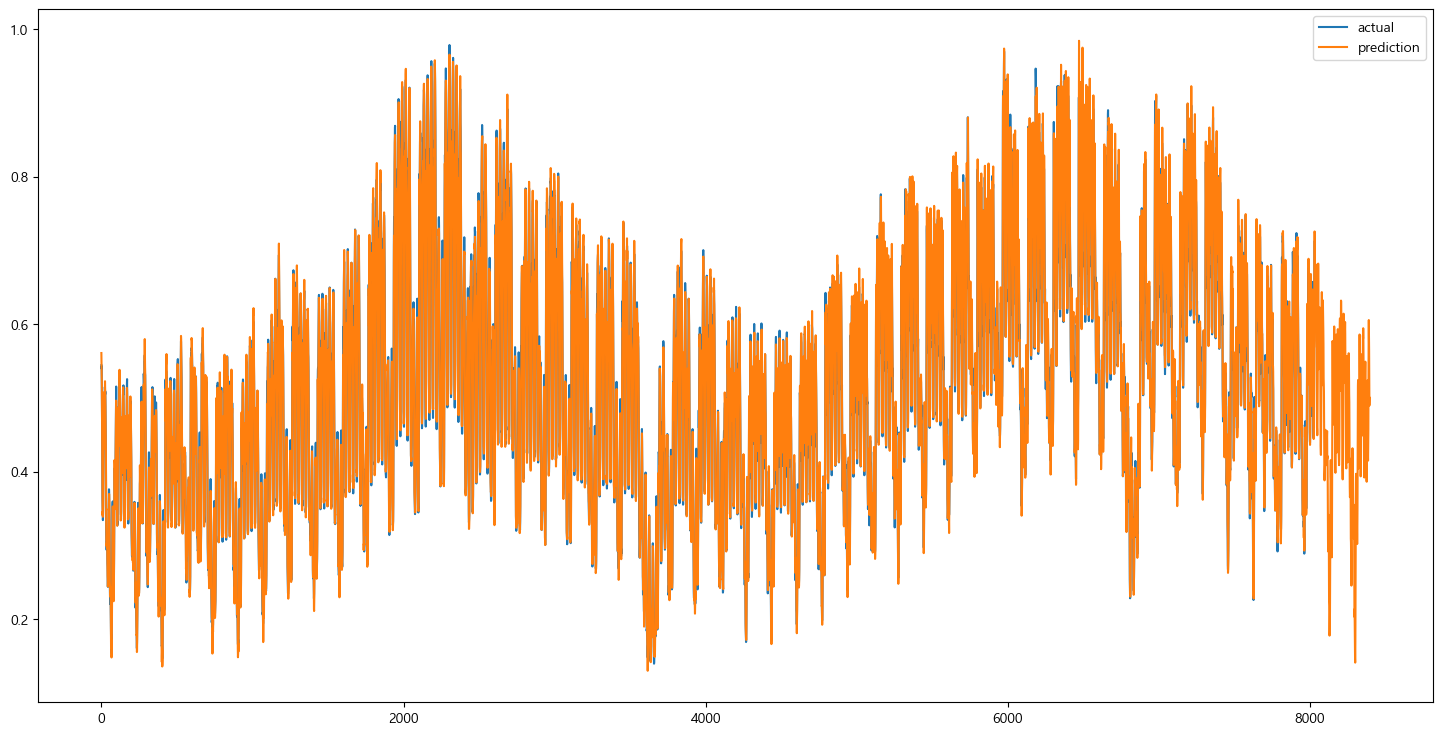

In [36]:
plt.figure(figsize=(18, 9))
plt.plot(np.asarray(y_test[:-365])[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [37]:
pred.shape

(8395, 1)

In [55]:
y_test[365:].set_index

AttributeError: 'Series' object has no attribute 'set_index'

In [39]:
type(pred)

numpy.ndarray

In [40]:
pred

array([[0.5609902 ],
       [0.53942424],
       [0.53149617],
       ...,
       [0.51255256],
       [0.48979214],
       [0.500316  ]], dtype=float32)

In [41]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
preds = pred.flatten()
margin_of_error = preds - y_test[:-365]

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error /y_test[:-365]).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Margin of error: 77578    0.229143
77579    0.180270
77580    0.146726
77581    0.105411
77582    0.026655
           ...   
85968    0.128983
85969    0.080201
85970   -0.017794
85971   -0.115307
85972   -0.211599
Name: 현재수요(MW), Length: 8395, dtype: float64
MAE: 0.00403535184795132
MPE: 10.162428054271297
MSE: 0.03627984941368792
RMSE: 0.19047269991704302


In [42]:
import numpy as np

# Create a sample dataset
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# Normalize the data using min-max normalization
min_val = np.min(data)
max_val = np.max(data)
data_norm = (data - min_val) / (max_val - min_val)

# Revert the normalized data
data_reverted = (preds * (max_val - min_val)) + min_val

print("Original data:", data)
print("Normalized data:", data_norm)
print("Reverted data:", data_reverted)


Original data: 0        64355.00000
1        64355.00000
2        64559.16667
3        64845.00000
4        64845.00000
            ...     
77573    77170.92500
77574    77757.55000
77575    78301.11667
77576    77992.78333
77577    77427.35833
Name: 공급능력(MW), Length: 77578, dtype: float64
Normalized data: 0        0.049615
1        0.049615
2        0.053143
3        0.058082
4        0.058082
           ...   
77573    0.271091
77574    0.281228
77575    0.290622
77576    0.285293
77577    0.275522
Name: 공급능력(MW), Length: 77578, dtype: float64
Reverted data: [93946.26  92698.32  92239.555 ... 91143.37  89826.31  90435.29 ]


In [43]:
import numpy as np

# 샘플 데이터 생성
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# 최소-최대 정규화를 사용하여 데이터 정규화
min_val = np.min(data)
max_val = np.max(data)
# data_norm = (data - min_val) / (max_val - min_val)

# 정규화된 데이터를 되돌리기
data_reverted_Y = (y_test[:-365] * (max_val - min_val)) + min_val

print("원본 데이터:", data)
print("정규화된 데이터:", data_norm)
print("되돌린 데이터:", data_reverted)


원본 데이터: 0        64355.00000
1        64355.00000
2        64559.16667
3        64845.00000
4        64845.00000
            ...     
77573    77170.92500
77574    77757.55000
77575    78301.11667
77576    77992.78333
77577    77427.35833
Name: 공급능력(MW), Length: 77578, dtype: float64
정규화된 데이터: 0        0.049615
1        0.049615
2        0.053143
3        0.058082
4        0.058082
           ...   
77573    0.271091
77574    0.281228
77575    0.290622
77576    0.285293
77577    0.275522
Name: 공급능력(MW), Length: 77578, dtype: float64
되돌린 데이터: [93946.26  92698.32  92239.555 ... 91143.37  89826.31  90435.29 ]


In [44]:
data_reverted

array([93946.26 , 92698.32 , 92239.555, ..., 91143.37 , 89826.31 ,
       90435.29 ], dtype=float32)

In [45]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
preds = pred.flatten()
margin_of_error = data_reverted - data_reverted_Y

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error /y_test[:-365]).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Margin of error: 77578    13259.581403
77579    10431.498447
77580     8490.417183
77581     6099.684924
77582     1542.433026
             ...     
85968     7463.750223
85969     4640.918219
85970    -1029.684693
85971    -6672.367904
85972   -12244.388834
Name: 현재수요(MW), Length: 8395, dtype: float64
MAE: 233.509701477749
MPE: 588059.0723559664
MSE: 121482130.84621264
RMSE: 11021.893251443358


In [52]:
pred.shape

(8395, 1)

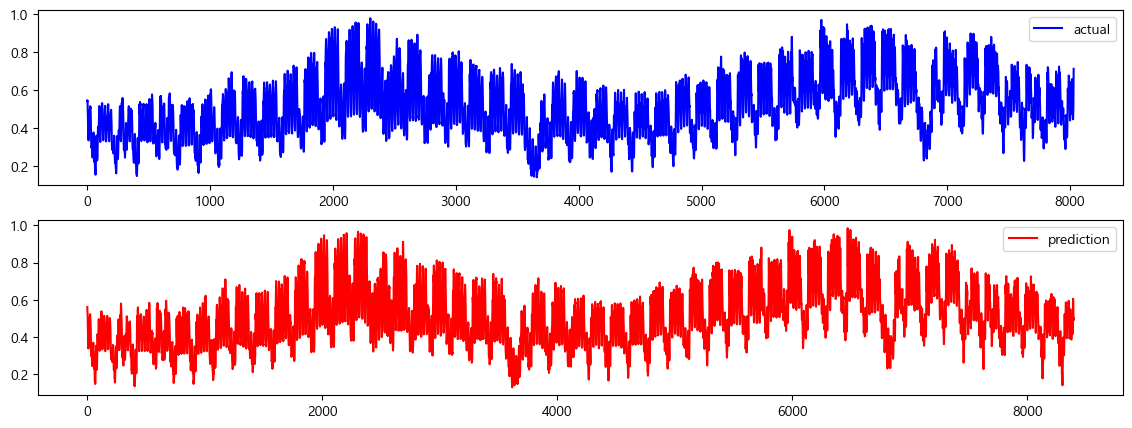

In [60]:
fig = plt.figure(figsize=(14, 5)) # 그림 사이즈 지정 (가로 14인치, 세로 5인치)
ax1 = fig.add_subplot(2, 1, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(2, 1, 2) # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

ax1.plot(np.asarray(y_test[:-365])[WINDOW_SIZE:], label='actual', color='blue')
ax1.legend()
ax2.plot(pred, label='prediction', color='red')
ax2.legend()
plt.show()

In [53]:
y_test[:-365].shape

(8395,)

In [ ]:
import numpy as np

# 샘플 데이터 생성
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# 최소-최대 정규화를 사용하여 데이터 정규화
min_val = np.min(data)
max_val = np.max(data)
# data_norm = (data - min_val) / (max_val - min_val)

# 정규화된 데이터를 되돌리기
data_reverted_Y = (y_test[:-365] * (max_val - min_val)) + min_val

print("원본 데이터:", data)
print("정규화된 데이터:", data_norm)
print("되돌린 데이터:", data_reverted)


In [58]:
pred = pred.flatten()

In [62]:
def smape(true, pred):
    v = abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    max_p = np.max(v)
    min_p = np.min(v)
    return max_p
a= smape(y_test[:-365],pred)

In [64]:
import numpy as np

# 샘플 데이터 생성
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# 최소-최대 정규화를 사용하여 데이터 정규화
min_val = np.min(data)
max_val = np.max(data)
# data_norm = (data - min_val) / (max_val - min_val)

# 정규화된 데이터를 되돌리기
data_reverted_Y = (a * (max_val - min_val)) + min_val

print("원본 데이터:", data)
print("정규화된 데이터:", data_norm)
print("되돌린 데이터:", data_reverted_Y)


원본 데이터: 0        64355.00000
1        64355.00000
2        64559.16667
3        64845.00000
4        64845.00000
            ...     
77573    77170.92500
77574    77757.55000
77575    78301.11667
77576    77992.78333
77577    77427.35833
Name: 공급능력(MW), Length: 77578, dtype: float64
정규화된 데이터: 0        0.049615
1        0.049615
2        0.053143
3        0.058082
4        0.058082
           ...   
77573    0.271091
77574    0.281228
77575    0.290622
77576    0.285293
77577    0.275522
Name: 공급능력(MW), Length: 77578, dtype: float64
되돌린 데이터: 97011.04893478606


In [ ]:
def smape(true, pred):
    v = abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output
print(smape(y_test[:-365],pred))

In [46]:
data_reverted_Y

77578     80686.676409
77579     82266.821866
77580     83749.137505
77581     85511.143201
77582     87871.441974
             ...      
85968     87959.999777
85969     89483.800531
85970     92173.051880
85971     96498.680404
85972    102679.677896
Name: 현재수요(MW), Length: 8395, dtype: float64

In [47]:
data_reverted

array([93946.26 , 92698.32 , 92239.555, ..., 91143.37 , 89826.31 ,
       90435.29 ], dtype=float32)